<a href="https://colab.research.google.com/github/sithin42/INT-PROSTATE-Contour-Stability/blob/main/2_RadiomicsFeatureExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

ROOT_PATH = "./"
#Loading the example data from github
if IN_COLAB:
  ROOT_PATH = "./INT-PROSTATE-Contour-Stability"
  !git clone https://github.com/sithin42/INT-PROSTATE-Contour-Stability.git
  import sys
  sys.path.append(ROOT_PATH)
  

fatal: destination path 'INT-PROSTATE-Contour-Stability' already exists and is not an empty directory.


In [16]:
#Requirements 
!pip install torchio
!pip install SimpleITK
!pip install pyradiomics
!pip install pandas


In [17]:
import os
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
import radiomics
import torchio as tio
import pandas as pd
from utils import ContourInPlaneAug, ContourOutPlaneAug, vol_dice_score, get_aug_fn

from ipywidgets import widgets, interact
import matplotlib.pyplot as plt

In [18]:
import logging
# set level for all classes
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)#To ignore feature warnings

# Data IO

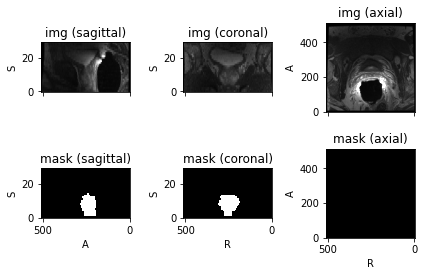

In [19]:
PID = "PCAMPMRI-00002"

img_path = os.path.join(ROOT_PATH,"data",PID,"image.nii.gz")
mask_path = os.path.join(ROOT_PATH,"data",PID,"mask.nii.gz")
  
sub = tio.Subject(img=tio.ScalarImage(img_path),mask=tio.LabelMap(mask_path))
sub.plot()#Fast Visualization

In [20]:
#Interactive Visualization

sitk_img = sitk.ReadImage(img_path)
sitk_mask = sitk.ReadImage(mask_path)

img_arr = sitk.GetArrayFromImage(sitk_img)#Z,X,Y
mask_arr = sitk.GetArrayFromImage(sitk_mask)

spacing_W, spacing_H, _ = sitk_img.GetSpacing()

def visualize(i):
    
    plt.imshow(img_arr[i],cmap='gray')
    if mask_arr[i].sum()>0:
        plt.contour(mask_arr[i])
    plt.show()
    
interact(visualize, i=widgets.IntSlider(len(mask_arr)//2,0,len(mask_arr),1))

interactive(children=(IntSlider(value=15, description='i', max=30), Output()), _dom_classes=('widget-interact'…

<function __main__.visualize>

#Classical Radiomics Feature Extraction

In [21]:
PATIENT_IDS = ["PCAMPMRI-00001","PCAMPMRI-00002"]
PARAM_SETTINGS = os.path.join(ROOT_PATH,"paramSettings/StudySettings3D.yaml")

In [22]:
extractor = radiomics.featureextractor.RadiomicsFeatureExtractor(PARAM_SETTINGS,verbosity=False)

In [23]:
def extract_features(pids):

  features = []

  pbar = tqdm(range(len(PATIENT_IDS)), desc="Extracting Features")

  for id in pids:

    img_path = os.path.join(ROOT_PATH,"data",id,"image.nii.gz")
    mask_path = os.path.join(ROOT_PATH,"data",id,"mask.nii.gz")

    featureVector = extractor.execute(img_path,mask_path)

    featureVector["id"] = id
    featureVector["dice"] = 1.0 #because this is the ground truth ROI
    featureVector["judge"] = 0

    features.append(featureVector)

    pbar.update()

  df = pd.DataFrame(features)

  return df


In [24]:
df = extract_features(PATIENT_IDS)
if not os.path.exists("./results"):
  os.makedirs("./results")
df.to_csv("./results/org_feats.csv")
df.head()

Extracting Features: 100%|██████████| 2/2 [00:27<00:00, 13.71s/it]


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,diagnostics_Image-interpolated_Spacing,diagnostics_Image-interpolated_Size,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_Spacing,diagnostics_Mask-interpolated_Size,diagnostics_Mask-interpolated_BoundingBox,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,diagnostics_Mask-interpolated_CenterOfMassIndex,diagnostics_Mask-interpolated_CenterOfMass,diagnostics_Mask-interpolated_Mean,diagnostics_Mask-interpolated_Minimum,diagnostics_Mask-interpolated_Maximum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,...,exponential_glrlm_ShortRunHighGrayLevelEmphasis,exponential_glrlm_ShortRunLowGrayLevelEmphasis,exponential_glszm_GrayLevelNonUniformity,exponential_glszm_GrayLevelNonUniformityNormalized,exponential_glszm_GrayLevelVariance,exponential_glszm_HighGrayLevelZoneEmphasis,exponential_glszm_LargeAreaEmphasis,exponential_glszm_LargeAreaHighGrayLevelEmphasis,exponential_glszm_LargeAreaLowGrayLevelEmphasis,exponential_glszm_LowGrayLevelZoneEmphasis,exponential_glszm_SizeZoneNonUniformity,exponential_glszm_SizeZoneNonUniformityNormalized,exponential_glszm_SmallAreaEmphasis,exponential_glszm_SmallAreaHighGrayLevelEmphasis,exponential_glszm_SmallAreaLowGrayLevelEmphasis,exponential_glszm_ZoneEntropy,exponential_glszm_ZonePercentage,exponential_glszm_ZoneVariance,exponential_ngtdm_Busyness,exponential_ngtdm_Coarseness,exponential_ngtdm_Complexity,exponential_ngtdm_Contrast,exponential_ngtdm_Strength,exponential_gldm_DependenceEntropy,exponential_gldm_DependenceNonUniformity,exponential_gldm_DependenceNonUniformityNormalized,exponential_gldm_DependenceVariance,exponential_gldm_GrayLevelNonUniformity,exponential_gldm_GrayLevelVariance,exponential_gldm_HighGrayLevelEmphasis,exponential_gldm_LargeDependenceEmphasis,exponential_gldm_LargeDependenceHighGrayLevelEmphasis,exponential_gldm_LargeDependenceLowGrayLevelEmphasis,exponential_gldm_LowGrayLevelEmphasis,exponential_gldm_SmallDependenceEmphasis,exponential_gldm_SmallDependenceHighGrayLevelEmphasis,exponential_gldm_SmallDependenceLowGrayLevelEmphasis,id,dice,judge
0,v3.0.1,1.19.5,2.1.1,1.1.1,3.7.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4...",3113612f2899bbba113384f1747b9b716ad30be8,3D,"(0.3125, 0.3125, 3.0)","(512, 512, 30)",391.272048,0.0,11139.0,58c60672e6a2abd8d3caa3ca421d0f37989a4b73,"(0.3125, 0.3125, 3.0)","(512, 512, 30)","(180, 193, 7, 154, 103, 12)",94679,1,"(253.96146980851086, 247.28200551336622, 13.49...","(1.66226046262058, -12.186775620823056, -10.49...","(0.3, 0.3, 3.3)","(185, 131, 28)",58.454832,-154.803072,1207.870512,"(0.3, 0.3, 3.3)","(185, 131, 28)","(12, 12, 6, 156, 107, 11)",89917,1,"(89.24102227609907, 68.21153953090072, 11.9548...","(1.5653578302906581, -12.305190484479791, -11....",136.385329,-74.360766,823.600007,0.819156,0.723521,29.428380,...,0.43819237007685125,0.1676602885504717,3.0,0.2727272727272727,2.0826446280991737,10.545454545454545,723296640.2727273,723392911.0909091,723273603.2202272,0.2365909090909091,1.1818181818181819,0.10743801652892562,0.21282897367314338,3.783304145797264,0.0324471953801

#In-Silico Contour Generation & Feature Extraction

In [25]:

AUG_COUNT = 15
AUG_TYPE = "in_plane"
BIAS_TYPE = "random"

IN_AUG_PARAMS = {'w_spacing':None,"h_spacing":None,'w_stdMM':2.7,'h_stdMM':2.7, 'angle':5,'bias_type':None}
OUT_AUG_PARAMS = {'scale_a':0.6,'scale_b':0.8,'angle':5,'delta_z':2}

PATIENT_IDS = ["PCAMPMRI-00001","PCAMPMRI-00002"]
PARAM_SETTINGS = os.path.join(ROOT_PATH,"paramSettings/StudySettings3D.yaml")

In [26]:
extractor = radiomics.featureextractor.RadiomicsFeatureExtractor(PARAM_SETTINGS,verbosity=False)

In [27]:
def extract_aug_features(pids, aug_type, bias_type, aug_count):
    
    features = []

    pbar = tqdm(range(aug_count*len(pids)), desc="Extracting Features", position=0)

    for pid in pids:

      img = sitk.ReadImage(os.path.join(ROOT_PATH,"data",pid,"image.nii.gz"))
      mask = sitk.ReadImage(os.path.join(ROOT_PATH,"data",pid,"mask.nii.gz"))

      img_arr = sitk.GetArrayFromImage(img)
      mask_arr = sitk.GetArrayFromImage(mask)

      aug_fn = get_aug_fn(aug_type, bias_type, img.GetSpacing(), IN_AUG_PARAMS, OUT_AUG_PARAMS)
      subject = tio.Subject(img=tio.ScalarImage(tensor=img_arr[np.newaxis,...]),mask=tio.LabelMap(tensor=mask_arr[np.newaxis,...]))

      for i in range(aug_count):

          pbar.set_description(f"Extracting Features {pid} - Synthetic ROI #{i+1}")

          aug_subject = aug_fn(subject)
          aug_mask_arr = aug_subject["mask"]["data"][0].numpy()

          dice = vol_dice_score(aug_mask_arr,mask_arr)

          aug_mask = sitk.GetImageFromArray(aug_mask_arr)
          aug_mask.SetSpacing(img.GetSpacing())
          aug_mask.SetOrigin(img.GetOrigin())

          featureVector = extractor.execute(img,aug_mask)

          featureVector['id'] = pid
          featureVector['dice'] = dice
          featureVector['judge'] = i+1

          features.append(featureVector)
          pbar.update()
            
                    
    aug_df = pd.DataFrame(features)

    return aug_df


In [29]:
aug_df = extract_aug_features(PATIENT_IDS,AUG_TYPE,BIAS_TYPE,AUG_COUNT)

out_path = f"./results/{AUG_TYPE}_{BIAS_TYPE}"

if not os.path.exists(out_path):
  os.makedirs(out_path)
aug_df.to_csv(os.path.join(out_path,"aug_feats.csv"))
aug_df.head()

Extracting Features PCAMPMRI-00002 - Synthetic ROI #15: 100%|██████████| 30/30 [07:34<00:00, 15.15s/it]


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,diagnostics_Image-interpolated_Spacing,diagnostics_Image-interpolated_Size,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_Spacing,diagnostics_Mask-interpolated_Size,diagnostics_Mask-interpolated_BoundingBox,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,diagnostics_Mask-interpolated_CenterOfMassIndex,diagnostics_Mask-interpolated_CenterOfMass,diagnostics_Mask-interpolated_Mean,diagnostics_Mask-interpolated_Minimum,diagnostics_Mask-interpolated_Maximum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,...,exponential_glrlm_ShortRunHighGrayLevelEmphasis,exponential_glrlm_ShortRunLowGrayLevelEmphasis,exponential_glszm_GrayLevelNonUniformity,exponential_glszm_GrayLevelNonUniformityNormalized,exponential_glszm_GrayLevelVariance,exponential_glszm_HighGrayLevelZoneEmphasis,exponential_glszm_LargeAreaEmphasis,exponential_glszm_LargeAreaHighGrayLevelEmphasis,exponential_glszm_LargeAreaLowGrayLevelEmphasis,exponential_glszm_LowGrayLevelZoneEmphasis,exponential_glszm_SizeZoneNonUniformity,exponential_glszm_SizeZoneNonUniformityNormalized,exponential_glszm_SmallAreaEmphasis,exponential_glszm_SmallAreaHighGrayLevelEmphasis,exponential_glszm_SmallAreaLowGrayLevelEmphasis,exponential_glszm_ZoneEntropy,exponential_glszm_ZonePercentage,exponential_glszm_ZoneVariance,exponential_ngtdm_Busyness,exponential_ngtdm_Coarseness,exponential_ngtdm_Complexity,exponential_ngtdm_Contrast,exponential_ngtdm_Strength,exponential_gldm_DependenceEntropy,exponential_gldm_DependenceNonUniformity,exponential_gldm_DependenceNonUniformityNormalized,exponential_gldm_DependenceVariance,exponential_gldm_GrayLevelNonUniformity,exponential_gldm_GrayLevelVariance,exponential_gldm_HighGrayLevelEmphasis,exponential_gldm_LargeDependenceEmphasis,exponential_gldm_LargeDependenceHighGrayLevelEmphasis,exponential_gldm_LargeDependenceLowGrayLevelEmphasis,exponential_gldm_LowGrayLevelEmphasis,exponential_gldm_SmallDependenceEmphasis,exponential_gldm_SmallDependenceHighGrayLevelEmphasis,exponential_gldm_SmallDependenceLowGrayLevelEmphasis,id,dice,judge
0,v3.0.1,1.19.5,2.1.1,1.1.1,3.7.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4...",3113612f2899bbba113384f1747b9b716ad30be8,3D,"(0.3125, 0.3125, 3.0)","(512, 512, 30)",391.272048,0.0,11139.0,8c05a5c720ebd7c5b39159b04a61b0b3c93416e7,"(0.3125, 0.3125, 3.0)","(512, 512, 30)","(177, 190, 7, 155, 107, 12)",92226,1,"(253.90885433608744, 247.3316852080758, 13.416...","(1.645818127488269, -12.17125071622631, -10.71...","(0.3, 0.3, 3.3)","(186, 135, 28)",56.306342,-154.803072,1284.221496,"(0.3, 0.3, 3.3)","(186, 135, 28)","(12, 12, 6, 162, 111, 11)",87948,1,"(92.12348205757948, 71.33916632555601, 11.8968...","(1.5300957647347673, -12.266902446083211, -11....",135.868106,-75.565873,823.600007,0.808833,0.707908,28.864105,...,0.31187529193879404,0.18800968570533844,3.6,0.36,0.64,6.4,765446668.2,765490802.7,765436014.7,0.26458333333333334,1.4,0.14,0.1644581361643216,0.8049051345458971,0.03705075730896574,3.321928094887359,0.00011370355209896757,688098161.16,36.21396657697612,0.0046208930